In [ ]:
!pip install albumentations
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [ ]:
!pip install segmentation-models-pytorch
!pip install torchsummary


In [ ]:
!pip install huggingface-hub==0.16.4


In [144]:
import segmentation_models_pytorch as smp
from torchsummary import summary


In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


device(type='cuda')

In [146]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cu118


In [147]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 3060


In [148]:
import os
import pandas as pd

# Define paths to the train, valid, and test image and mask folders
import os
import glob

main_folder = r'D:\ML_Seagrass\SourceData\Washington\Washington'

# Define the folders for images, masks, and additional channels
train_image_folder = os.path.join(main_folder, 'train', 'image')
train_mask_folder = os.path.join(main_folder, 'train', 'index')
val_image_folder = os.path.join(main_folder, 'valid', 'image')
val_mask_folder = os.path.join(main_folder, 'valid', 'index')
test_image_folder = os.path.join(main_folder, 'test', 'image')
test_mask_folder = os.path.join(main_folder, 'test', 'index')
train_ch4_folder = os.path.join(main_folder, 'train', 'glcm')
train_ch5_folder = os.path.join(main_folder, 'train', 'glcm')
valid_ch4_folder = os.path.join(main_folder, 'valid', 'glcm')
valid_ch5_folder = os.path.join(main_folder, 'valid', 'glcm')

# Collect file paths for each set using glob
train_image_files = glob.glob(os.path.join(train_image_folder, '*.png'))  # Adjust extension as needed
train_mask_files = glob.glob(os.path.join(train_mask_folder, '*.png'))
val_image_files = glob.glob(os.path.join(val_image_folder, '*.png'))
val_mask_files = glob.glob(os.path.join(val_mask_folder, '*.png'))
test_image_files = glob.glob(os.path.join(test_image_folder, '*.png'))
test_mask_files = glob.glob(os.path.join(test_mask_folder, '*.png'))

train_ch4_files = glob.glob(os.path.join(train_ch4_folder, '*.png'))
train_ch5_files = glob.glob(os.path.join(train_ch5_folder, '*.png'))
valid_ch4_files = glob.glob(os.path.join(valid_ch4_folder, '*.png'))
valid_ch5_files = glob.glob(os.path.join(valid_ch5_folder, '*.png'))

# Verify the number of files collected
print("Number of training images:", len(train_image_files))
print("Number of training masks:", len(train_mask_files))
print("Number of validation images:", len(val_image_files))
print("Number of validation masks:", len(val_mask_files))
print("Number of training ch4 images:", len(train_ch4_files))
print("Number of training ch5 images:", len(train_ch5_files))
print("Number of validation ch4 images:", len(valid_ch4_files))
print("Number of validation ch5 images:", len(valid_ch5_files))

    
# Function to create dataframes from the given folder structure
def create_dataframes_from_main_folder(main_folder):
    

    # Helper function to create a dataframe from image and mask folders
    def create_dataframe_from_folders(image_folder, mask_folder):
        image_names = [img.split('.')[0] for img in os.listdir(image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
        mask_names = [mask.split('.')[0] for mask in os.listdir(mask_folder) if mask.endswith(('.jpg', '.png', '.jpeg'))]

        # Ensure that the image and mask file names match
        assert set(image_names) == set(mask_names), "Image and mask file names do not match!"

        return pd.DataFrame({'id': image_names})

    # Create dataframes for train, valid, and test sets
    df_train = create_dataframe_from_folders(train_image_folder, train_mask_folder)
    df_val = create_dataframe_from_folders(val_image_folder, val_mask_folder)
    df_test = create_dataframe_from_folders(test_image_folder, test_mask_folder)

    # Return dataframes
    return df_train, df_val, df_test

  # Replace with the path to your main folder
df_train, df_val, df_test = create_dataframes_from_main_folder(main_folder)

# Assign X_train, X_val, and X_test
X_train = df_train['id'].values
X_val = df_val['id'].values
X_test = df_test['id'].values


Number of training images: 1201
Number of training masks: 1201
Number of validation images: 343
Number of validation masks: 343
Number of training ch4 images: 1201
Number of training ch5 images: 1201
Number of validation ch4 images: 343
Number of validation ch5 images: 343


Image Path: D:\ML_Seagrass\SourceData\Washington\Washington\valid\image\BH_WA_19_row10_col5.png
Mask Path: D:\ML_Seagrass\SourceData\Washington\Washington\valid\index\BH_WA_19_row10_col5.png


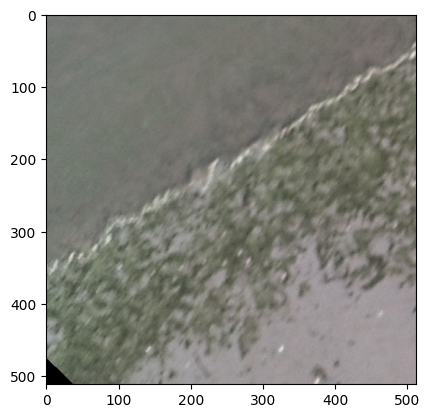

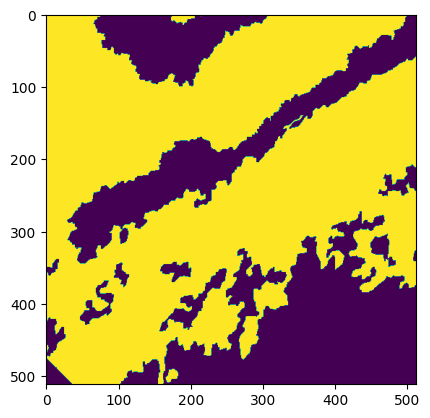

(512, 512, 3)
(512, 512)


In [149]:
for idx in X_val:
    img_path = os.path.join(val_image_folder, idx + '.png')
    mask_path = os.path.join(val_mask_folder, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [150]:
from pathlib import Path

class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, ch4_path, ch5_path, X, mean, std, transform=None, patch=False):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch
        self.ch4_path = ch4_path
        self.ch5_path = ch5_path

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        img_ch4_path = os.path.join(self.ch4_path ,f'{self.X[idx]}.png')
        if self.ch5_path is not None and len(self.ch5_path)>1:
            img_ch5_path = os.path.join(self.ch5_path, f'{self.X[idx]}.png')
        else:
            img_ch5_path = None
                    
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_ch4 = cv2.imread(str(img_ch4_path), cv2.IMREAD_GRAYSCALE)
        
        img_ch5 = None
        if img_ch5_path is not None:
            img_ch5 = cv2.imread(str(img_ch5_path), cv2.IMREAD_GRAYSCALE)
            
        img_ch4 = np.expand_dims(img_ch4, axis=2)
        img_with_4ch = np.concatenate((img, img_ch4), axis=2)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        mask = np.array(mask)

        # Map mask values: 255 -> 1
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        # if self.transform is not None:
        #     aug = self.transform(image=img, mask=mask)
        #     img = aug['image']
        #     mask = aug['mask']
            
        if self.transform is not None:
            print(f'img_with_4ch: {img_with_4ch.shape}  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
            aug = self.transform(image=img_with_4ch, mask=mask)
            img_with_4ch = aug['image']
            mask = aug['mask']
            
            print(f'img_with_4ch: {img_with_4ch.shape}  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb')
            
        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        # img = t(img)
        img = t(img_with_4ch)
        
        # Convert mask to a tensor
        mask = torch.from_numpy(mask).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        print(f'img: {img.shape}  cccccccccccccccccccccccccccccccccc')
        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass

In [151]:
from torch.utils.data import Dataset
import torch
import numpy as np
from skimage import io

class Drone_data_5xxx(Dataset):
    def __init__(self, image_paths, mask_paths, ch4_paths, ch5_paths, transform=None, eval_ori_resolution=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.ch4_paths = ch4_paths
        self.ch5_paths = ch5_paths
        self.transform = transform
        self.eval_ori_resolution = eval_ori_resolution

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the main RGB image
        image_path = self.image_paths[idx]
        image = io.imread(image_path)
        print(f"Loaded image shape: {image.shape}")

        # Load the corresponding mask (ground truth)
        mask_path = self.mask_paths[idx]
        mask = io.imread(mask_path)

        # Load additional channels
        ch4_path = self.ch4_paths[idx]
        ch4 = io.imread(ch4_path)
        
        ch5_path = self.ch5_paths[idx]
        ch5 = io.imread(ch5_path)

        # Ensure mask is grayscale
        if len(mask.shape) > 2:
            mask = mask[:, :, 0]

        # Ensure the main image has 3 channels
        if len(image.shape) < 3:
            image = image[:, :, np.newaxis]
        if image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)

        # Ensure additional channels are single-channel
        if ch4.shape[2] > 1:
            ch4 = ch4[:, :, 0]
        if ch5.shape[2] > 1:
            ch5 = ch5[:, :, 0]

        # Convert additional channels to the correct shape
        ch4 = ch4[:, :, np.newaxis]
        ch5 = ch5[:, :, np.newaxis]

        # Concatenate the original image with the additional channels
        image_5channel = np.concatenate((image, ch4, ch5), axis=2)

        # Convert to PyTorch tensors and rearrange dimensions
        image_5channel = torch.tensor(image_5channel.copy(), dtype=torch.float32)
        image_5channel = torch.permute(image_5channel, (2, 0, 1))

        image = torch.tensor(image.copy(), dtype=torch.float32)
        image = torch.permute(image, (2, 0, 1))

        mask = torch.unsqueeze(torch.tensor(mask, dtype=torch.float32), 0)

        # Prepare the sample as a dictionary
        sample = {
            "imidx": torch.tensor(idx),
            "image": image,
            "label": mask,
            "shape": torch.tensor(image.shape[-2:]),
            "image_5channel": image_5channel
        }

        # Apply transformations if provided
        if self.transform:
            sample = self.transform(sample)

        # Add original resolution labels and paths for evaluation if required
        if self.eval_ori_resolution:
            sample["ori_label"] = mask.type(torch.uint8)  # For evaluation only, without transformations
            sample['ori_im_path'] = image_path
            sample['ori_gt_path'] = mask_path

        return sample


In [152]:
import albumentations as A
import cv2
from torch.utils.data import DataLoader

# Mean and standard deviation for 5 channels (adjust last two values for ch4 and ch5)
mean = [0.485, 0.456, 0.406, 0.5]
std = [0.229, 0.224, 0.225, 0.22]

# Define Albumentations transforms
t_train = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
    A.GaussNoise()
])

t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
])

# Create datasets using the lists of actual file paths
# train_set = Drone_data(
#     image_paths=train_image_files,  # List of image file paths
#     mask_paths=train_mask_files,    # List of mask file paths
#     ch4_paths=train_ch4_files,      # List of ch4 image file paths
#     ch5_paths=train_ch5_files,      # List of ch5 image file paths
#     transform=t_train,
#     eval_ori_resolution=False  # Set to True if you want to include original paths and labels for evaluation
# )

# val_set = Drone_data(
#     image_paths=val_image_files,  # List of validation image file paths
#     mask_paths=val_mask_files,    # List of validation mask file paths
#     ch4_paths=valid_ch4_files,    # List of validation ch4 image file paths
#     ch5_paths=valid_ch5_files,    # List of validation ch5 image file paths
#     transform=t_val,
#     eval_ori_resolution=False  # Set to True if you want to include original paths and labels for evaluation
# )

train_set = Drone_data(train_image_folder, train_mask_folder,train_ch4_folder, None, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(val_image_folder, val_mask_folder, valid_ch4_folder, None, X_val, mean, std, t_val, patch=False)

# Create dataloaders
batch_size = 4
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)



In [153]:
# import albumentations as A
# import cv2
# from torch.utils.data import DataLoader

# # Mean and standard deviation for 5 channels (adjust last two values for ch4 and ch5)
# mean = [0.485, 0.456, 0.406, 0.5, 0.5]  
# std = [0.229, 0.224, 0.225, 0.2, 0.2]

# # Define Albumentations transforms
# t_train = A.Compose([
#     A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
#     A.HorizontalFlip(),
#     A.VerticalFlip(),
#     A.GridDistortion(p=0.2),
#     A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
#     A.GaussNoise()
# ])

# t_val = A.Compose([
#     A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
#     A.HorizontalFlip(),
#     A.GridDistortion(p=0.2)
# ])

# # Create datasets using the lists of actual file paths
# train_set = Drone_data(
#     image_paths=train_image_files,  # List of image file paths
#     mask_paths=train_mask_files,    # List of mask file paths
#     ch4_paths=train_ch4_files,      # List of ch4 image file paths
#     ch5_paths=train_ch5_files,      # List of ch5 image file paths
#     transform=t_train,
#     eval_ori_resolution=False  # Set to True if you want to include original paths and labels for evaluation
# )

# val_set = Drone_data(
#     image_paths=val_image_files,  # List of validation image file paths
#     mask_paths=val_mask_files,    # List of validation mask file paths
#     ch4_paths=valid_ch4_files,    # List of validation ch4 image file paths
#     ch5_paths=valid_ch5_files,    # List of validation ch5 image file paths
#     transform=t_val,
#     eval_ori_resolution=False  # Set to True if you want to include original paths and labels for evaluation
# )

# # Create dataloaders
# batch_size = 4
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)



In [154]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', in_channels=3, classes=2, activation=None)

In [155]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

In [156]:
class ChannelReducer(nn.Module):
    def __init__(self):
        super(ChannelReducer, self).__init__()
        self.conv = nn.Conv2d(4, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        return self.conv(x)

class UnetWith5Channels(nn.Module):
    def __init__(self, unet_model):
        super(UnetWith5Channels, self).__init__()
        self.channel_reducer = ChannelReducer()
        self.unet = unet_model
    

    def forward(self, x):
        x = self.channel_reducer(x)
        return self.unet(x)


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model = UnetWith5Channels(model)####
    
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # Unpack the 5-channel image and mask tiles from the dataloader
            # image_tiles = data["image_5channel"]
            # mask_tiles = data["label"]
            image_tiles, mask_tiles = data
            
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            # Move the images and masks to the specified device (e.g., GPU)
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            # Forward pass with 5-channel image
            output = model(image)

            # Calculate loss
            loss = criterion(output, mask)

            # Calculate evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # Unpack the 5-channel image and mask tiles from the dataloader
                    # image_tiles = data["image_5channel"]
                    # mask_tiles = data["label"]
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            if min_loss > (test_loss / len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score / len(val_loader)))

            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time() - since) / 60))

    history = {'train_loss': train_losses, 'val_loss': test_losses,
               'train_miou': train_iou, 'val_miou': val_iou,
               'train_acc': train_acc, 'val_acc': val_acc,
               'lrs': lrs}

    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    return history


In [157]:
torch.cuda.empty_cache()

In [158]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

Sat Nov  2 22:03:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 38%   53C    P8             12W /  170W |    1620MiB /  12288MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [159]:
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

torch.save(model, 'Unet-mobilenet2-batchsize4-WA_lr-4._4CHANNEL.pt')

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/301 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

  0%|          | 0/86 [00:00<?, ?it/s]

img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (

In [160]:
model_path = r'C:\Users\Yang_PC\Documents\Github\ArcgisPro-Customized-Toolbox\Notebook\Unet-mobilenet2-batchsize4-WA_lr-4._4CHANNEL.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path)
model.to(device)




Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [161]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

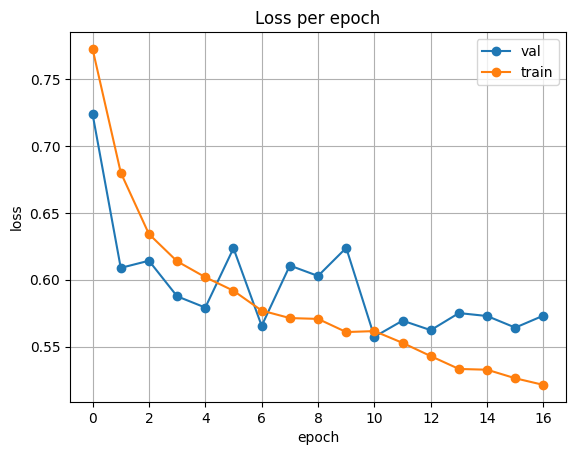

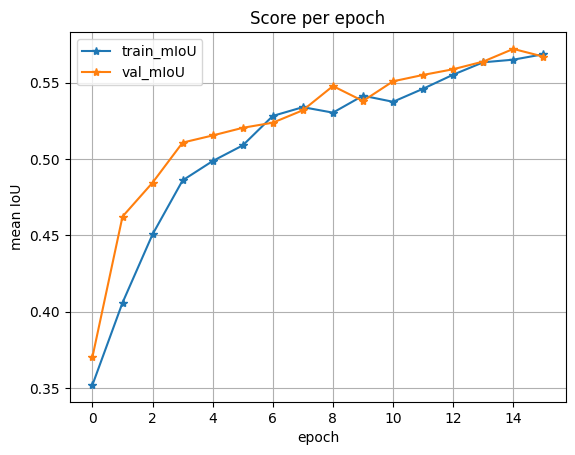

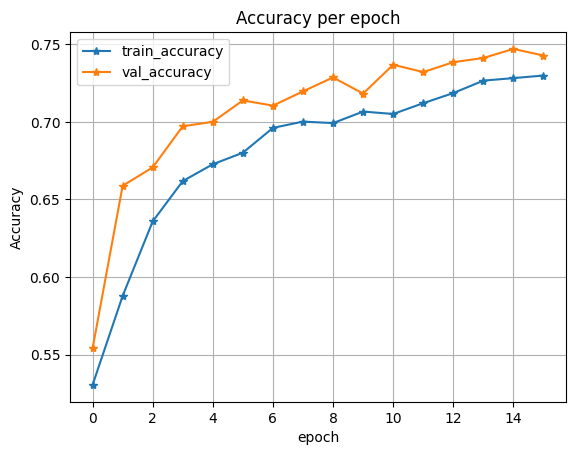

In [162]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [170]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_file_name = f'{self.X[idx]}.png'
        img_path = self.img_path / img_file_name
        mask_path = self.mask_path / img_file_name
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        # Return the image, mask, and file name
        return img, mask, img_file_name

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(test_image_folder, test_mask_folder, X_test, transform=t_test)

In [173]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Updated function to perform inference and save the predicted mask with resizing
def predict_image_mask_miou(model, image, mask, save_file, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode
    
    # Store original image dimensions before transforming
    original_height, original_width = 512, 512  # PIL Image size: (width, height)
    
    # Apply transformation to the image (e.g., normalization)
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image_tensor = t(image)  # Keep 'image' unchanged for later use
    
    # Move image and mask to the appropriate device
    image_tensor = image_tensor.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension for the model
        mask = mask.unsqueeze(0)    # Add batch dimension

        output = model(image_tensor)  # Run model inference
        score = mIoU(output, mask)  # Compute mIoU score
        
        # Get the predicted mask by taking the argmax of the model's output
        pred_mask = torch.argmax(output, dim=1)
        pred_mask = pred_mask.cpu().squeeze(0)  # Move to CPU and remove batch dimension

    # Resize the predicted mask to match the original image size
    pred_mask_resized = cv2.resize(pred_mask.numpy(), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    
    # Save the resized predicted mask as a grayscale image
    plt.imsave(save_file, pred_mask_resized, cmap='gray')  # Save mask as a grayscale image
    
    return pred_mask_resized, score



def save_predicted_mask_overlay(pred_mask, img_file_name, image_folder, save_file, alpha=0.5):
    """
    Overlays the predicted mask on the original image read from a specified folder, and saves the result.
    
    Parameters:
    - pred_mask: The predicted mask (PyTorch tensor or NumPy array with values 0 and 1).
    - img_file_name: The name of the image file (e.g., 'image_001.png').
    - image_folder: The path to the folder where the original image is located.
    - save_file: The path to save the overlaid image.
    - alpha: The transparency factor for the overlay (default is 0.3 for higher transparency).
    """
    # Build the full image path
    img_path = os.path.join(image_folder, img_file_name)

    # Read the original image from the specified folder
    original_image = Image.open(img_path).convert('RGB')  # Use PIL to read the image
    original_image = np.array(original_image)  # Convert to NumPy array

    # Convert the predicted mask to a NumPy array if it's a PyTorch tensor
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    # Ensure the predicted mask has 2D shape (height, width)
    if pred_mask.ndim != 2:
        raise ValueError(f"Expected 2D mask, but got shape {pred_mask.shape}")

    # Resize the predicted mask to match the original image size (assuming original image size is 512x512)
    original_height, original_width = original_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Ensure the image is in the correct format (height, width, 3)
    if original_image.ndim != 3 or original_image.shape[2] != 3:
        raise ValueError(f"Expected 3D RGB image, but got shape {original_image.shape}")

    # Create a copy of the original image to modify
    overlay = original_image.copy()

    # Broadcast the mask across the 3 RGB channels (set the mask area to light blue)
    light_blue_color = [78,156,217]  # Light blue RGB
    light_blue_mask = np.zeros_like(overlay)
    light_blue_mask[pred_mask_resized == 1] = light_blue_color  # Light blue for class 1 (object)

    # Blend the original image and the light blue mask, keeping the original image intensity intact
    blended_image = cv2.addWeighted(light_blue_mask, alpha, original_image, 1, 0)

    # Save the blended image
    plt.imsave(save_file, blended_image)
    print(f"Saved overlay image: {save_file}")


In [175]:
import os
from tqdm import tqdm

# Define the save path for the predicted masks and the folder for original images
original_image_folder = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\image'  # Folder with original images
save_path = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay'
Pred_mask_path = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\predicted'

# Ensure the directories exist
os.makedirs(save_path, exist_ok=True)
os.makedirs(Pred_mask_path, exist_ok=True)

# Loop through all images in the test set
for idx in tqdm(range(len(test_set))):
    image, mask, img_file_name = test_set[idx]  # Get mask and filename from test_set
    
    # Define the save path for the current predicted mask
    save_overlay_file = os.path.join(save_path, f'{img_file_name}')  # Save with filename
    save_predicted_file = os.path.join(Pred_mask_path, f'{img_file_name}')
     
    # Run inference to get the predicted mask
    pred_mask, score = predict_image_mask_miou(model, image, mask, save_predicted_file)
    
    # Save the overlay of the predicted mask on the original image read from `original_image_folder`
    save_predicted_mask_overlay(pred_mask, img_file_name, original_image_folder, save_overlay_file)
    
    # Optionally, log the progress or save additional data
    print(f"Saved predicted mask for {img_file_name} with mIoU score: {score:.3f}")


  1%|          | 1/172 [00:00<00:59,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_19_row4_col12.png
Saved predicted mask for BH_WA_19_row4_col12.png with mIoU score: 0.628


  1%|          | 2/172 [00:00<00:57,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_19_row6_col11.png
Saved predicted mask for BH_WA_19_row6_col11.png with mIoU score: 0.412


  2%|▏         | 3/172 [00:01<01:02,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row12_col10.png
Saved predicted mask for BH_WA_20_row12_col10.png with mIoU score: 0.876


  2%|▏         | 4/172 [00:01<01:00,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row12_col6.png
Saved predicted mask for BH_WA_20_row12_col6.png with mIoU score: 0.107


  3%|▎         | 5/172 [00:01<01:05,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row2_col17.png
Saved predicted mask for BH_WA_20_row2_col17.png with mIoU score: 0.761


  3%|▎         | 6/172 [00:02<01:05,  2.54it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row3_col16.png
Saved predicted mask for BH_WA_20_row3_col16.png with mIoU score: 0.681


  4%|▍         | 7/172 [00:02<01:01,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row8_col10.png
Saved predicted mask for BH_WA_20_row8_col10.png with mIoU score: 0.605


  5%|▍         | 8/172 [00:02<00:58,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row9_col14.png
Saved predicted mask for BH_WA_20_row9_col14.png with mIoU score: 0.531


  5%|▌         | 9/172 [00:03<00:59,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row9_col8.png
Saved predicted mask for BH_WA_20_row9_col8.png with mIoU score: 0.336


  6%|▌         | 10/172 [00:03<00:56,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row12_col8.png
Saved predicted mask for BH_WA_21_row12_col8.png with mIoU score: 0.848


  6%|▋         | 11/172 [00:03<00:56,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row3_col15.png
Saved predicted mask for BH_WA_21_row3_col15.png with mIoU score: 0.649


  7%|▋         | 12/172 [00:04<00:58,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row4_col13.png
Saved predicted mask for BH_WA_21_row4_col13.png with mIoU score: 0.943


  8%|▊         | 13/172 [00:04<00:58,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row5_col14.png
Saved predicted mask for BH_WA_21_row5_col14.png with mIoU score: 0.156


  8%|▊         | 14/172 [00:05<00:58,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row6_col12.png
Saved predicted mask for BH_WA_21_row6_col12.png with mIoU score: 0.389


  9%|▊         | 15/172 [00:05<00:58,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row8_col8.png
Saved predicted mask for BH_WA_21_row8_col8.png with mIoU score: 0.826


  9%|▉         | 16/172 [00:05<00:57,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row9_col12.png
Saved predicted mask for BH_WA_21_row9_col12.png with mIoU score: 0.344


 10%|▉         | 17/172 [00:06<00:58,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row12_col8.png
Saved predicted mask for BH_WA_22_row12_col8.png with mIoU score: 0.142


 10%|█         | 18/172 [00:06<00:57,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row6_col17.png
Saved predicted mask for BH_WA_22_row6_col17.png with mIoU score: 0.109


 11%|█         | 19/172 [00:06<00:51,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row7_col13.png
Saved predicted mask for BH_WA_22_row7_col13.png with mIoU score: 0.786


 12%|█▏        | 20/172 [00:07<00:58,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row7_col15.png
Saved predicted mask for BH_WA_22_row7_col15.png with mIoU score: 0.390


 12%|█▏        | 21/172 [00:07<00:58,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row8_col13.png
Saved predicted mask for BH_WA_22_row8_col13.png with mIoU score: 0.366


 13%|█▎        | 22/172 [00:07<00:51,  2.94it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row9_col9.png
Saved predicted mask for BH_WA_22_row9_col9.png with mIoU score: 0.840


 13%|█▎        | 23/172 [00:08<00:51,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row10_col11.png
Saved predicted mask for FB_WA_19_row10_col11.png with mIoU score: 0.185


 14%|█▍        | 24/172 [00:08<00:51,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row10_col8.png
Saved predicted mask for FB_WA_19_row10_col8.png with mIoU score: 0.335


 15%|█▍        | 25/172 [00:09<00:51,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row11_col11.png
Saved predicted mask for FB_WA_19_row11_col11.png with mIoU score: 0.286


 15%|█▌        | 26/172 [00:09<00:50,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row11_col3.png
Saved predicted mask for FB_WA_19_row11_col3.png with mIoU score: 0.663


 16%|█▋        | 28/172 [00:09<00:42,  3.36it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row13_col3.png
Saved predicted mask for FB_WA_19_row13_col3.png with mIoU score: 0.453
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row2_col6.png
Saved predicted mask for FB_WA_19_row2_col6.png with mIoU score: 0.368


 17%|█▋        | 29/172 [00:10<00:36,  3.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row2_col8.png
Saved predicted mask for FB_WA_19_row2_col8.png with mIoU score: 0.539


 18%|█▊        | 31/172 [00:10<00:30,  4.59it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row3_col14.png
Saved predicted mask for FB_WA_19_row3_col14.png with mIoU score: 0.892
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row4_col3.png
Saved predicted mask for FB_WA_19_row4_col3.png with mIoU score: 0.698


 19%|█▊        | 32/172 [00:10<00:30,  4.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row4_col8.png
Saved predicted mask for FB_WA_19_row4_col8.png with mIoU score: 0.483


 19%|█▉        | 33/172 [00:10<00:34,  4.07it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col15.png
Saved predicted mask for FB_WA_19_row5_col15.png with mIoU score: 0.259


 20%|█▉        | 34/172 [00:11<00:36,  3.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col16.png
Saved predicted mask for FB_WA_19_row5_col16.png with mIoU score: 0.513


 20%|██        | 35/172 [00:11<00:39,  3.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col21.png
Saved predicted mask for FB_WA_19_row5_col21.png with mIoU score: 0.910


 21%|██        | 36/172 [00:11<00:41,  3.27it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col22.png
Saved predicted mask for FB_WA_19_row5_col22.png with mIoU score: 0.944


 22%|██▏       | 37/172 [00:12<00:45,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row6_col19.png
Saved predicted mask for FB_WA_19_row6_col19.png with mIoU score: 0.251


 22%|██▏       | 38/172 [00:12<00:50,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row8_col18.png
Saved predicted mask for FB_WA_19_row8_col18.png with mIoU score: 0.620


 23%|██▎       | 39/172 [00:13<00:49,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row9_col10.png
Saved predicted mask for FB_WA_19_row9_col10.png with mIoU score: 0.207


 23%|██▎       | 40/172 [00:13<00:49,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row10_col6.png
Saved predicted mask for FB_WA_20_row10_col6.png with mIoU score: 0.593


 24%|██▍       | 41/172 [00:13<00:48,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row11_col15.png
Saved predicted mask for FB_WA_20_row11_col15.png with mIoU score: 0.935


 24%|██▍       | 42/172 [00:14<00:48,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row11_col7.png
Saved predicted mask for FB_WA_20_row11_col7.png with mIoU score: 0.816


 25%|██▌       | 43/172 [00:14<00:45,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row1_col14.png
Saved predicted mask for FB_WA_20_row1_col14.png with mIoU score: 0.476


 26%|██▌       | 44/172 [00:15<00:45,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row3_col16.png
Saved predicted mask for FB_WA_20_row3_col16.png with mIoU score: 0.924


 26%|██▌       | 45/172 [00:15<00:45,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row5_col8.png
Saved predicted mask for FB_WA_20_row5_col8.png with mIoU score: 0.820


 27%|██▋       | 46/172 [00:15<00:44,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row6_col10.png
Saved predicted mask for FB_WA_20_row6_col10.png with mIoU score: 0.472


 27%|██▋       | 47/172 [00:16<00:45,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row6_col9.png
Saved predicted mask for FB_WA_20_row6_col9.png with mIoU score: 0.114


 28%|██▊       | 48/172 [00:16<00:46,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row7_col7.png
Saved predicted mask for FB_WA_20_row7_col7.png with mIoU score: 0.478


 28%|██▊       | 49/172 [00:16<00:45,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row8_col12.png
Saved predicted mask for FB_WA_20_row8_col12.png with mIoU score: 0.444


 29%|██▉       | 50/172 [00:17<00:45,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row8_col9.png
Saved predicted mask for FB_WA_20_row8_col9.png with mIoU score: 0.325


 30%|██▉       | 51/172 [00:17<00:46,  2.62it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row7_col11.png
Saved predicted mask for FB_WA_21_row7_col11.png with mIoU score: 0.464


 30%|███       | 52/172 [00:17<00:42,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row7_col5.png
Saved predicted mask for FB_WA_21_row7_col5.png with mIoU score: 0.935


 31%|███       | 53/172 [00:18<00:44,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row8_col14.png
Saved predicted mask for FB_WA_21_row8_col14.png with mIoU score: 0.675


 31%|███▏      | 54/172 [00:18<00:45,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row6_col8.png
Saved predicted mask for FB_WA_22_row6_col8.png with mIoU score: 0.292


 32%|███▏      | 55/172 [00:19<00:45,  2.57it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col11.png
Saved predicted mask for FB_WA_22_row7_col11.png with mIoU score: 0.358


 33%|███▎      | 56/172 [00:19<00:44,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col12.png
Saved predicted mask for FB_WA_22_row7_col12.png with mIoU score: 0.231


 33%|███▎      | 57/172 [00:19<00:45,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col8.png
Saved predicted mask for FB_WA_22_row7_col8.png with mIoU score: 0.181


 34%|███▎      | 58/172 [00:20<00:46,  2.44it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row8_col10.png
Saved predicted mask for FB_WA_22_row8_col10.png with mIoU score: 0.940


 34%|███▍      | 59/172 [00:20<00:45,  2.48it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row8_col14.png
Saved predicted mask for FB_WA_22_row8_col14.png with mIoU score: 0.658


 35%|███▍      | 60/172 [00:21<00:41,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_19_row3_col10.png
Saved predicted mask for IC_WA_19_row3_col10.png with mIoU score: 0.788


 35%|███▌      | 61/172 [00:21<00:42,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_19_row4_col9.png
Saved predicted mask for IC_WA_19_row4_col9.png with mIoU score: 0.128


 36%|███▌      | 62/172 [00:21<00:41,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row10_col7.png
Saved predicted mask for IC_WA_20_row10_col7.png with mIoU score: 0.408


 37%|███▋      | 63/172 [00:22<00:41,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row11_col22.png
Saved predicted mask for IC_WA_20_row11_col22.png with mIoU score: 0.555


 37%|███▋      | 64/172 [00:22<00:41,  2.62it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row15_col15.png
Saved predicted mask for IC_WA_20_row15_col15.png with mIoU score: 0.796


 38%|███▊      | 65/172 [00:22<00:38,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row15_col17.png
Saved predicted mask for IC_WA_20_row15_col17.png with mIoU score: 0.866


 38%|███▊      | 66/172 [00:23<00:38,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row3_col11.png
Saved predicted mask for IC_WA_20_row3_col11.png with mIoU score: 0.897


 39%|███▉      | 67/172 [00:23<00:37,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row6_col17.png
Saved predicted mask for IC_WA_20_row6_col17.png with mIoU score: 0.818


 40%|███▉      | 68/172 [00:23<00:33,  3.12it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row6_col23.png
Saved predicted mask for IC_WA_20_row6_col23.png with mIoU score: 0.657


 40%|████      | 69/172 [00:24<00:34,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row7_col13.png
Saved predicted mask for IC_WA_20_row7_col13.png with mIoU score: 0.894


 41%|████      | 70/172 [00:24<00:34,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row8_col23.png
Saved predicted mask for IC_WA_20_row8_col23.png with mIoU score: 0.430


 41%|████▏     | 71/172 [00:24<00:34,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col18.png
Saved predicted mask for IC_WA_20_row9_col18.png with mIoU score: 0.402


 42%|████▏     | 72/172 [00:25<00:37,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col23.png
Saved predicted mask for IC_WA_20_row9_col23.png with mIoU score: 0.224


 42%|████▏     | 73/172 [00:25<00:32,  3.03it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col24.png
Saved predicted mask for IC_WA_20_row9_col24.png with mIoU score: 0.867


 43%|████▎     | 74/172 [00:26<00:33,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row10_col10.png
Saved predicted mask for IC_WA_21_row10_col10.png with mIoU score: 0.158


 44%|████▎     | 75/172 [00:26<00:33,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row10_col5.png
Saved predicted mask for IC_WA_21_row10_col5.png with mIoU score: 0.851


 44%|████▍     | 76/172 [00:26<00:33,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col11.png
Saved predicted mask for IC_WA_21_row12_col11.png with mIoU score: 0.196


 45%|████▍     | 77/172 [00:27<00:33,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col13.png
Saved predicted mask for IC_WA_21_row12_col13.png with mIoU score: 0.396


 45%|████▌     | 78/172 [00:27<00:35,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col14.png
Saved predicted mask for IC_WA_21_row12_col14.png with mIoU score: 0.541


 46%|████▌     | 79/172 [00:27<00:34,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col17.png
Saved predicted mask for IC_WA_21_row12_col17.png with mIoU score: 0.902


 47%|████▋     | 80/172 [00:28<00:33,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row13_col12.png
Saved predicted mask for IC_WA_21_row13_col12.png with mIoU score: 0.360


 47%|████▋     | 81/172 [00:28<00:40,  2.23it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row15_col9.png
Saved predicted mask for IC_WA_21_row15_col9.png with mIoU score: 0.919


 48%|████▊     | 82/172 [00:29<00:38,  2.36it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row6_col22.png
Saved predicted mask for IC_WA_21_row6_col22.png with mIoU score: 0.159


 49%|████▉     | 84/172 [00:29<00:31,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row7_col14.png
Saved predicted mask for IC_WA_21_row7_col14.png with mIoU score: 0.898
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row10_col9.png
Saved predicted mask for IC_WA_22_row10_col9.png with mIoU score: 0.879


 49%|████▉     | 85/172 [00:30<00:29,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row5_col9.png
Saved predicted mask for IC_WA_22_row5_col9.png with mIoU score: 0.784


 50%|█████     | 86/172 [00:30<00:28,  3.01it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row6_col16.png
Saved predicted mask for IC_WA_22_row6_col16.png with mIoU score: 0.939


 51%|█████     | 87/172 [00:30<00:29,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row8_col11.png
Saved predicted mask for IC_WA_22_row8_col11.png with mIoU score: 0.613


 51%|█████     | 88/172 [00:31<00:29,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row12_col14.png
Saved predicted mask for JF_WA_19_row12_col14.png with mIoU score: 0.020


 52%|█████▏    | 89/172 [00:31<00:29,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row13_col12.png
Saved predicted mask for JF_WA_19_row13_col12.png with mIoU score: 0.181


 52%|█████▏    | 90/172 [00:31<00:27,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row14_col14.png
Saved predicted mask for JF_WA_19_row14_col14.png with mIoU score: 0.627
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row14_col8.png
Saved predicted mask for JF_WA_19_row14_col8.png with mIoU score: 0.891


 53%|█████▎    | 92/172 [00:32<00:21,  3.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row15_col9.png
Saved predicted mask for JF_WA_19_row15_col9.png with mIoU score: 0.870


 54%|█████▍    | 93/172 [00:32<00:23,  3.42it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row2_col9.png
Saved predicted mask for JF_WA_19_row2_col9.png with mIoU score: 0.465


 55%|█████▍    | 94/172 [00:33<00:25,  3.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row7_col9.png
Saved predicted mask for JF_WA_19_row7_col9.png with mIoU score: 0.026


 55%|█████▌    | 95/172 [00:33<00:25,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row8_col6.png
Saved predicted mask for JF_WA_19_row8_col6.png with mIoU score: 0.131


 56%|█████▌    | 96/172 [00:33<00:25,  3.00it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row9_col18.png
Saved predicted mask for JF_WA_19_row9_col18.png with mIoU score: 0.263


 56%|█████▋    | 97/172 [00:34<00:25,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row10_col10.png
Saved predicted mask for JF_WA_20_row10_col10.png with mIoU score: 0.151


 57%|█████▋    | 98/172 [00:34<00:25,  2.94it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row13_col20.png
Saved predicted mask for JF_WA_20_row13_col20.png with mIoU score: 0.741


 58%|█████▊    | 99/172 [00:34<00:26,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col13.png
Saved predicted mask for JF_WA_20_row14_col13.png with mIoU score: 0.561


 58%|█████▊    | 100/172 [00:35<00:25,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col19.png
Saved predicted mask for JF_WA_20_row14_col19.png with mIoU score: 0.616


 59%|█████▊    | 101/172 [00:35<00:25,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col24.png
Saved predicted mask for JF_WA_20_row14_col24.png with mIoU score: 0.757


 59%|█████▉    | 102/172 [00:35<00:24,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row15_col24.png
Saved predicted mask for JF_WA_20_row15_col24.png with mIoU score: 0.867


 60%|█████▉    | 103/172 [00:36<00:24,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row17_col19.png
Saved predicted mask for JF_WA_20_row17_col19.png with mIoU score: 0.438


 60%|██████    | 104/172 [00:36<00:23,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row17_col22.png
Saved predicted mask for JF_WA_20_row17_col22.png with mIoU score: 0.256


 61%|██████    | 105/172 [00:36<00:25,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row19_col19.png
Saved predicted mask for JF_WA_20_row19_col19.png with mIoU score: 0.527


 62%|██████▏   | 106/172 [00:37<00:24,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row4_col7.png
Saved predicted mask for JF_WA_20_row4_col7.png with mIoU score: 0.673


 62%|██████▏   | 107/172 [00:37<00:24,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row6_col4.png
Saved predicted mask for JF_WA_20_row6_col4.png with mIoU score: 0.512


 63%|██████▎   | 108/172 [00:38<00:23,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row8_col16.png
Saved predicted mask for JF_WA_20_row8_col16.png with mIoU score: 0.929


 63%|██████▎   | 109/172 [00:38<00:23,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row9_col8.png
Saved predicted mask for JF_WA_20_row9_col8.png with mIoU score: 0.389


 64%|██████▍   | 110/172 [00:38<00:22,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col10.png
Saved predicted mask for JF_WA_21_row10_col10.png with mIoU score: 0.715


 65%|██████▍   | 111/172 [00:39<00:21,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col5.png
Saved predicted mask for JF_WA_21_row10_col5.png with mIoU score: 0.836


 65%|██████▌   | 112/172 [00:39<00:21,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col8.png
Saved predicted mask for JF_WA_21_row10_col8.png with mIoU score: 0.632


 66%|██████▌   | 113/172 [00:39<00:20,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row11_col19.png
Saved predicted mask for JF_WA_21_row11_col19.png with mIoU score: 0.145


 66%|██████▋   | 114/172 [00:40<00:20,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row11_col22.png
Saved predicted mask for JF_WA_21_row11_col22.png with mIoU score: 0.333


 67%|██████▋   | 115/172 [00:40<00:20,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row12_col14.png
Saved predicted mask for JF_WA_21_row12_col14.png with mIoU score: 0.892


 67%|██████▋   | 116/172 [00:40<00:20,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row12_col18.png
Saved predicted mask for JF_WA_21_row12_col18.png with mIoU score: 0.282


 68%|██████▊   | 117/172 [00:41<00:20,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row13_col12.png
Saved predicted mask for JF_WA_21_row13_col12.png with mIoU score: 0.368


 69%|██████▊   | 118/172 [00:41<00:19,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row14_col19.png
Saved predicted mask for JF_WA_21_row14_col19.png with mIoU score: 0.323


 69%|██████▉   | 119/172 [00:42<00:19,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row15_col22.png
Saved predicted mask for JF_WA_21_row15_col22.png with mIoU score: 0.302


 70%|██████▉   | 120/172 [00:42<00:19,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row15_col24.png
Saved predicted mask for JF_WA_21_row15_col24.png with mIoU score: 0.177


 70%|███████   | 121/172 [00:42<00:19,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row16_col20.png
Saved predicted mask for JF_WA_21_row16_col20.png with mIoU score: 0.361


 71%|███████   | 122/172 [00:43<00:18,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row16_col21.png
Saved predicted mask for JF_WA_21_row16_col21.png with mIoU score: 0.310


 72%|███████▏  | 123/172 [00:43<00:18,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col15.png
Saved predicted mask for JF_WA_21_row17_col15.png with mIoU score: 0.904


 72%|███████▏  | 124/172 [00:44<00:18,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col16.png
Saved predicted mask for JF_WA_21_row17_col16.png with mIoU score: 0.769


 73%|███████▎  | 125/172 [00:44<00:19,  2.42it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col22.png
Saved predicted mask for JF_WA_21_row17_col22.png with mIoU score: 0.473


 73%|███████▎  | 126/172 [00:44<00:17,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row18_col22.png
Saved predicted mask for JF_WA_21_row18_col22.png with mIoU score: 0.710


 74%|███████▍  | 127/172 [00:45<00:17,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row19_col16.png
Saved predicted mask for JF_WA_21_row19_col16.png with mIoU score: 0.825


 74%|███████▍  | 128/172 [00:45<00:16,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row21_col15.png
Saved predicted mask for JF_WA_21_row21_col15.png with mIoU score: 0.935


 75%|███████▌  | 129/172 [00:45<00:14,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row2_col8.png
Saved predicted mask for JF_WA_21_row2_col8.png with mIoU score: 0.749


 76%|███████▌  | 130/172 [00:46<00:14,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row5_col6.png
Saved predicted mask for JF_WA_21_row5_col6.png with mIoU score: 0.909


 76%|███████▌  | 131/172 [00:46<00:14,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row7_col10.png
Saved predicted mask for JF_WA_21_row7_col10.png with mIoU score: 0.616


 77%|███████▋  | 132/172 [00:46<00:14,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col11.png
Saved predicted mask for JF_WA_21_row8_col11.png with mIoU score: 0.158


 77%|███████▋  | 133/172 [00:47<00:13,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col14.png
Saved predicted mask for JF_WA_21_row8_col14.png with mIoU score: 0.230


 78%|███████▊  | 134/172 [00:47<00:14,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col18.png
Saved predicted mask for JF_WA_21_row8_col18.png with mIoU score: 0.116


 78%|███████▊  | 135/172 [00:47<00:12,  3.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col20.png
Saved predicted mask for JF_WA_21_row8_col20.png with mIoU score: 0.895


 79%|███████▉  | 136/172 [00:48<00:12,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row9_col11.png
Saved predicted mask for JF_WA_21_row9_col11.png with mIoU score: 0.486


 80%|███████▉  | 137/172 [00:48<00:11,  3.07it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_22_row3_col5.png
Saved predicted mask for JF_WA_22_row3_col5.png with mIoU score: 0.453


 80%|████████  | 138/172 [00:48<00:11,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row4_col8.png
Saved predicted mask for NC_WA_19_row4_col8.png with mIoU score: 0.450


 81%|████████  | 139/172 [00:49<00:11,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row4_col9.png
Saved predicted mask for NC_WA_19_row4_col9.png with mIoU score: 0.388


 81%|████████▏ | 140/172 [00:49<00:10,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row6_col4.png
Saved predicted mask for NC_WA_19_row6_col4.png with mIoU score: 0.920


 82%|████████▏ | 141/172 [00:49<00:10,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row10_col9.png
Saved predicted mask for NC_WA_20_row10_col9.png with mIoU score: 0.709


 83%|████████▎ | 142/172 [00:50<00:10,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row11_col13.png
Saved predicted mask for NC_WA_20_row11_col13.png with mIoU score: 0.480


 83%|████████▎ | 143/172 [00:50<00:10,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row11_col5.png
Saved predicted mask for NC_WA_20_row11_col5.png with mIoU score: 0.914


 84%|████████▎ | 144/172 [00:51<00:09,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row13_col10.png
Saved predicted mask for NC_WA_20_row13_col10.png with mIoU score: 0.535


 84%|████████▍ | 145/172 [00:51<00:09,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row13_col15.png
Saved predicted mask for NC_WA_20_row13_col15.png with mIoU score: 0.937


 85%|████████▍ | 146/172 [00:51<00:09,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row14_col8.png
Saved predicted mask for NC_WA_20_row14_col8.png with mIoU score: 0.825


 85%|████████▌ | 147/172 [00:52<00:10,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row15_col6.png
Saved predicted mask for NC_WA_20_row15_col6.png with mIoU score: 0.843


 86%|████████▌ | 148/172 [00:52<00:09,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row16_col11.png
Saved predicted mask for NC_WA_20_row16_col11.png with mIoU score: 0.725


 87%|████████▋ | 149/172 [00:53<00:08,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row17_col11.png
Saved predicted mask for NC_WA_20_row17_col11.png with mIoU score: 0.802


 88%|████████▊ | 151/172 [00:53<00:06,  3.20it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row18_col10.png
Saved predicted mask for NC_WA_20_row18_col10.png with mIoU score: 0.863
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row21_col18.png
Saved predicted mask for NC_WA_20_row21_col18.png with mIoU score: 0.947


 88%|████████▊ | 152/172 [00:53<00:05,  3.49it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row21_col6.png
Saved predicted mask for NC_WA_20_row21_col6.png with mIoU score: 0.946


 89%|████████▉ | 153/172 [00:54<00:06,  3.16it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row4_col17.png
Saved predicted mask for NC_WA_20_row4_col17.png with mIoU score: 0.291


 90%|████████▉ | 154/172 [00:54<00:05,  3.32it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row5_col19.png
Saved predicted mask for NC_WA_20_row5_col19.png with mIoU score: 0.597


 90%|█████████ | 155/172 [00:54<00:05,  3.17it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row7_col19.png
Saved predicted mask for NC_WA_20_row7_col19.png with mIoU score: 0.302


 91%|█████████ | 156/172 [00:55<00:05,  3.01it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row9_col12.png
Saved predicted mask for NC_WA_20_row9_col12.png with mIoU score: 0.466


 91%|█████████▏| 157/172 [00:55<00:05,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row10_col10.png
Saved predicted mask for NC_WA_21_row10_col10.png with mIoU score: 0.738


 92%|█████████▏| 158/172 [00:55<00:04,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row11_col8.png
Saved predicted mask for NC_WA_21_row11_col8.png with mIoU score: 0.366


 92%|█████████▏| 159/172 [00:56<00:04,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row7_col15.png
Saved predicted mask for NC_WA_21_row7_col15.png with mIoU score: 0.549


 93%|█████████▎| 160/172 [00:56<00:04,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row7_col18.png
Saved predicted mask for NC_WA_21_row7_col18.png with mIoU score: 0.252


 94%|█████████▎| 161/172 [00:56<00:03,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row8_col1.png
Saved predicted mask for NC_WA_21_row8_col1.png with mIoU score: 0.863


 94%|█████████▍| 162/172 [00:57<00:03,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row8_col8.png
Saved predicted mask for NC_WA_21_row8_col8.png with mIoU score: 0.915


 95%|█████████▍| 163/172 [00:57<00:03,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row9_col16.png
Saved predicted mask for NC_WA_21_row9_col16.png with mIoU score: 0.901


 95%|█████████▌| 164/172 [00:58<00:02,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row10_col5.png
Saved predicted mask for NC_WA_22_row10_col5.png with mIoU score: 0.452


 96%|█████████▌| 165/172 [00:58<00:02,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row5_col14.png
Saved predicted mask for NC_WA_22_row5_col14.png with mIoU score: 0.663


 97%|█████████▋| 166/172 [00:58<00:02,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row6_col13.png
Saved predicted mask for NC_WA_22_row6_col13.png with mIoU score: 0.445


 97%|█████████▋| 167/172 [00:59<00:01,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row7_col13.png
Saved predicted mask for NC_WA_22_row7_col13.png with mIoU score: 0.738


 98%|█████████▊| 168/172 [00:59<00:01,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row7_col14.png
Saved predicted mask for NC_WA_22_row7_col14.png with mIoU score: 0.760


 98%|█████████▊| 169/172 [00:59<00:01,  2.37it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col11.png
Saved predicted mask for NC_WA_22_row8_col11.png with mIoU score: 0.527


 99%|█████████▉| 170/172 [01:00<00:00,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col7.png
Saved predicted mask for NC_WA_22_row8_col7.png with mIoU score: 0.370


 99%|█████████▉| 171/172 [01:00<00:00,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col9.png
Saved predicted mask for NC_WA_22_row8_col9.png with mIoU score: 0.636


100%|██████████| 172/172 [01:00<00:00,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row9_col4.png
Saved predicted mask for NC_WA_22_row9_col4.png with mIoU score: 0.857
